# LSTM Tuning on Spooky Author Identification Dataset

This is an example of tuning LSTM architectures with an NLP dataset of exerpts from the writings of three authors. The objective is to tune an LSTM model that can predict the author from a writing exerpt.

The steps taken in this notebook are:

- Split data into train/valid/test sets
- Prepare vocabulary
- Tokenise the sentences and labels with IDs
- Batching and padding for LSTM input
- Define a class that can build an RNN with variable hidden units and layers
- Setup training and validation code
- Prepare a hyper parameter tuner using Grid Search
- Tune an LSTM/GRU over the hyper-parameters for multiple epochs
- (Plotting results)

In [1]:
import os.path
import csv

Firstly, read in the CSV data, and take a quick look.

In [2]:
datadir = 'data/spooky_author_identification/'
csv_train = os.path.join(datadir, 'train.csv')
csv_test  = os.path.join(datadir, 'test.csv')
filesdir = 'files/'

In [3]:
# Read in CSV data
def read_csv(filepath, discard_header=False):
    data_raw = []
    with open(filepath) as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if not row:
                continue
            if discard_header and i == 0:
                continue
            data_raw.append(row)
    return data_raw

In [4]:
train_raw = read_csv(csv_train, discard_header=True)
test_raw  = read_csv(csv_test, discard_header=True)

### Dataset Contents

Below is a sample of the data. It has been imported here as a list of lists, where each entry contains an ID for the entry, a text phrase as a complete string, and the author initials. The texts are sentence excerpts from the authors books, and there are three authors in the dataset: 
- EAP: Edgar Allan Poe, 
- HPL: HP Lovecraft, 
- MWS: Mary Wollstonecraft Shelley. 

In [5]:
for text_id, text, author in train_raw[:4]:
    print('{:10} {:5}\n{}\n'.format(text_id, author, text))

id26305    EAP  
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.

id17569    HPL  
It never once occurred to me that the fumbling might be a mere mistake.

id11008    EAP  
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.

id27763    MWS  
How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.



### Dataset Quantity

There are 19,579 entries in the "training" set, and 8,392 entries in the test set. The test set contains only the ID and text, so the author needs to be predicted for submission of results. So the "training" set will actually need to be divided into a train and validation set at least.

In [6]:
print('{} entries in training set'.format(len(train_raw)))
print('{} entries in test set'.format(len(test_raw)))

19579 entries in training set
8392 entries in test set


### Splitting Data into Train/Valid/Test Datasets

Using a previous tool I prepared for the common task of making a train/valid/test split. Copied to this notebook directory to ensure import. Subclass the DataManager class for this particular dataset. In the current implementation, two functions need to be defined to handle the specific processing of the current dataset.

`_process_row_raw()`

Processes the raw data from the original CSV file. This method treats a single row from the original data format, and outputs a format that will be split into train/valid/test files.

`_process_row_split()`

This method treats a single row of the train/valid/test files generated with the previous method, and outputs the format that will actually be used for training -- so just the most necessary variables.

What the data manager tool does is read in the csv, divide the data by classes, then randomly samples from each class to build up the various sets. Firstly train is filled, then valid, then test. The sets are filled in the proportions specified. This gives each set an even distribution of examples from each class.

In [7]:
import data_tools as dt
from data_tools import DataManager

class SpookyData(DataManager):
    def __init__(self, filepath, split, one_hot_encode=True, output_numpy=True):
        super().__init__(filepath, split, one_hot_encode, output_numpy)
        self.filepath = filepath
        self.split = split       # train/valid/test fractions, should sum to 1
        self.dataset_path = 'data/spooky_author_identification/processed'
        self.discard_header = True

    def _process_row_raw(self, row):
        """
        Import lines from raw data file.
        Imports line of "ID, text, author"
        Returns list of [ID, text, author, author_index]
        """
        read_line = []
        spooky_id    = row[0]
        spooky_text  = row[1]
        spooky_label = row[2]
        label_idx = self._get_idx(spooky_label)
        read_line.extend([spooky_id, spooky_text, spooky_label, label_idx])
        return read_line

    def _process_row_split(self, row):
        """
        Import lines from train/valid/test split files.
        Imports line of "ID, text, author, author_index"
        Returns list of [text, author]
        """
        read_line = []

        spooky_text      = row[1]
        spooky_label     = row[2]
        spooky_label_idx = int(float(row[-1]))
        fetch_idx = self._get_idx(spooky_label)  # rebuilds num_classes
        read_line.extend([spooky_text, spooky_label])
        return read_line

The above subclass of DataManager handles the specific data structure of the Spooky Author Identification dataset. Now instantiate it with a train/valid/test 80%/10%/10% split. Since we later want to generate a vocabulary, we don't want the labels to be one-hot-encoded yet. We also want python lists as inputs for building the vocabulary

In [8]:
# NLP Spooky Author Identification Dataset
filepath = 'data/spooky_author_identification/train.csv'
data_manager = dt.SpookyData(filepath, (0.8, 0.1, 0.1), one_hot_encode=False, output_numpy=False)
data_manager.init_dataset()
train_x, train_y = data_manager.prepare_train()

Preparing Train/Valid/Test data from data/spooky_author_identification/train.csv
Split test has (790, 564, 605) examples of each class
Split train has (6320, 4508, 4835) examples of each class
Split valid has (790, 563, 604) examples of each class
Dataset prepared


**Some Remarks**

These counts show that about 40% of the dataset is Edgar Allan Poe, about 29% HP Lovecraft, and 31% Mary wollstonecraft Shelly. The train/valid/test sets have been filled with this ratio. The train/valid/test sets themselves containt 80%/10%/10% of the total dataset.

### Prepare Vocabulary

The input dataset has been processed into train/valid/test divisions, but still contains sentences and labels as input. To be able to process these with an LSTM model, these sentences need to be converted into numbers. This is done by building a vocabulary of the words in a corpus (the training dataset here), where the words are counted and arranged by frequency.

Below a Vocabulary class is defined for carrying out this task. Parts of this class will be explained step by step.

In [9]:
import os.path
import re

# String to use for padding or unknown token
_PAD = "_PAD"
_UNK = "_UNK"

# Padding for 0 index, if used
START_VOCAB_dict = dict()
START_VOCAB_dict['with_padding'] = [_PAD, _UNK]
START_VOCAB_dict['no_padding'] = [_UNK]

# UNK ID depends if padding is used or not
UNK_ID_dict = dict()
UNK_ID_dict['with_padding'] = 1
UNK_ID_dict['no_padding'] = 0

# Regular expressions used to tokenize.
_WORD_SPLIT = re.compile("([.,!?\"':;)(])")
_DIGIT_RE = re.compile(r"\d")

class Vocabulary(object):
    def __init__(self, datadir, max_vocabulary_size):
        self.datadir = datadir
        if not os.path.exists(self.datadir):
            os.makedirs(self.datadir)
        self.max_vocabulary_size = max_vocabulary_size
        self.corpus_file        = 'sentences_raw.txt'
        self.vocab_file         = 'vocab_sentences.txt'
        self.label_file         = 'vocab_labels.txt'

        # train/valid/test file names
        self.sentences_file     = 'sentences.txt'
        self.labels_file        = 'labels.txt'
        self.ids_sentences_file = 'ids_sentences.txt'
        self.ids_labels_file    = 'ids_labels.txt'

        self.tokeniser = self.basic_tokeniser

        self.vocab_list = []
        self.label_list = []

        self.vocab_to_id = {}
        self.id_to_vocab = []
        self.label_to_id = {}
        self.id_to_label = []

    def build_vocabulary(self, sentences, labels):
        self.build_sentence_vocabulary(sentences)
        self.build_label_vocabulary(labels)

    def build_sentence_vocabulary(self, sentences, normalise_digits=True):
        """Build vocabulary from a list of sentences"""
        # write sentences (corpus) to file
        sentences_raw_path = os.path.join(self.datadir, self.corpus_file)
        if not os.path.exists(sentences_raw_path):
            print('Creating sentence corpus in {}'.format(sentences_raw_path))
            self._write_file_from_list(sentences_raw_path, sentences)

        # Build vocabulary from list
        print("Building vocabulary")
        counter = 0
        vocab = {}  # Count occurrences of each word
        for sentence in sentences:
            counter += 1
            if counter % 5000 == 0:
                print("  processing line {}".format(counter))
            tokens = self.tokeniser(sentence)
            for w in tokens:
                word = re.sub(_DIGIT_RE, "0", w) if normalise_digits else w
                if word in vocab:
                    vocab[word] += 1
                else:
                    vocab[word] = 1
        vocab_list = START_VOCAB_dict['with_padding'] + sorted(vocab, key=vocab.get, reverse=True)
        if len(vocab_list) > self.max_vocabulary_size:
            vocab_list = vocab_list[:self.max_vocabulary_size]
        self.vocab_list = vocab_list

        # Write vocabulary to file
        vocab_path = os.path.join(self.datadir, self.vocab_file)
        self._write_file_from_list(vocab_path, vocab_list)

    def build_label_vocabulary(self, labels):
        labels = sorted(set(labels))
        self.label_list = labels
        label_path = os.path.join(self.datadir, self.label_file)
        self._write_file_from_list(label_path, labels)

    def get_sentence_vocabulary(self):
        vocab, rev_vocab = self.initialise_vocabulary(self.vocab_list)
        self.vocab_to_id = vocab
        self.id_to_vocab = rev_vocab
        return vocab, rev_vocab

    def get_label_vocabulary(self):
        vocab, rev_vocab = self.initialise_vocabulary(self.label_list)
        self.label_to_id = vocab
        self.id_to_label = rev_vocab
        return vocab, rev_vocab

    def initialise_vocabulary(self, vocabulary_list):
        """
        Initialise vocabulary from vocabulary list
        Build Vocab > ID dictionary, and ID > Vocab list.
        """
        rev_vocab = [line.strip() for line in vocabulary_list]
        vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
        return vocab, rev_vocab

    def basic_tokeniser(self, sentence):
        """Very basic tokenizer: split the sentence into a list of tokens."""
        words = []
        for space_separated_fragment in sentence.strip().split():
            words.extend(re.split(_WORD_SPLIT, space_separated_fragment))
        return [w for w in words if w]

    def sentence_to_token_ids(self, sentence, UNK_ID, normalise_digits=True):
        words = self.tokeniser(sentence)
        if not normalise_digits:
            return [self.vocab_to_id.get(w, UNK_ID) for w in words]
        # Normalize digits by 0 before looking words up in the vocabulary.
        return [self.vocab_to_id.get(re.sub(_DIGIT_RE, "0", w), UNK_ID) for w in words]

    def data_to_token_ids(self, data, split_name, use_padding=True, normalise_digits=True):
        """
        Converts a list of data into its token IDs, writes
        them to a file, and returns the ID form of the data
        """
        tokenised_data = []
        for i, line in enumerate(data):
            if i % 5000 == 0 and i != 0:
                print('  tokenising line {}'.format(i))
            if use_padding:
                UNK_ID = UNK_ID_dict['with_padding']
            else:
                UNK_ID = UNK_ID_dict['no_padding']
            token_ids = self.sentence_to_token_ids(line, UNK_ID, normalise_digits)
            tokenised_data.append(token_ids)

        # write file
        write_dir = os.path.join(self.datadir, split_name)
        if not os.path.exists(write_dir):
            os.makedirs(write_dir)
        sents_file     = os.path.join(write_dir, self.sentences_file)
        ids_sents_file = os.path.join(write_dir, self.ids_sentences_file)

        self._write_file_from_list(sents_file, data)
        self._write_file_from_list(ids_sents_file, tokenised_data)
        return tokenised_data

    def labels_to_token_ids(self, labels, split_name):
        tokenised_labels = []
        for label in labels:
            tokenised_labels.append(self.label_to_id[label])

        # write file
        write_dir = os.path.join(self.datadir, split_name)
        if not os.path.exists(write_dir):
            os.makedirs(write_dir)
        labels_file     = os.path.join(write_dir, self.labels_file)
        ids_labels_file = os.path.join(write_dir, self.ids_labels_file)

        self._write_file_from_list(labels_file, labels)
        self._write_file_from_list(ids_labels_file, tokenised_labels)
        return tokenised_labels

    def translate_examples(self, examples):
        for sentence_tokens, label_token in examples:
            sentence_list = []
            for token in sentence_tokens:
                sentence_list.append(self.id_to_vocab[token])
            sentence = " ".join(sentence_list)
            label = self.id_to_label[label_token]
            print("{}\n{}\n\n".format(sentence, label))


    def _write_file_from_list(self, filename, write_list):
        print('Writing {} ...'.format(filename))
        with open(filename,'w') as file:
            for write_line in write_list:
                if not isinstance(write_line, (str, int)):
                    write_line = " ".join([str(item) for item in write_line])
                file.write(str(write_line) + "\n")

#### Build Vocabulary

Firstly, build the vocabulary with the training split. `build_vocabulary()` calls `build_sentence_vocabulary()` to build vocabulary for the sentences, and `build_label_vocabulary()` for the labels. For the sentences, the sentences are looped through and tokenised (basically split into words, and splitting out punctuation). Then the occurrences of each word are counted, the resulting list sorted (most frequent to least), and finally truncated to the vocabulary size. For the labels it's much more simple, just a sorted set of all the labels in the data, where the set is removing all duplicate occurrences of the labels.

Presumably, we're trying to identify an author based on writing style, so word choice and punctuation usage will be characteristic of each author. There may also be indication of genre or expressive style also from the words used. It should be noted here that the words have not been forced to lower case, for example, and capitalisation of words will be considered as separate vocabulary. Forcing everything to lower case could improve accuracy by increasing the vocabulary (different words) and treating words with the same letters as the same entity (unification), however you also lose some information on capitalisation too (which if used enough, could form an author's style).

#### Padding and Unknown Tokens

There are two special tokens added to the sentence vocabulary. One is a padding token (`_PAD`), which has no meaning, but is used to pad sequences in a batch to the same length. Typically this is at the 0 index, so 0 can be used for padding. Then there is an Unknown token (`_UNK`), which is used for any word that is not in the vocabulary. Here this is at the 1 index.

In [10]:
processed_path = 'data/spooky_author_identification/processed/'
vocab = Vocabulary(processed_path, 20000)
vocab.build_vocabulary(train_x, train_y)

Creating sentence corpus in data/spooky_author_identification/processed/sentences_raw.txt
Writing data/spooky_author_identification/processed/sentences_raw.txt ...
Building vocabulary
  processing line 5000
  processing line 10000
  processing line 15000
Writing data/spooky_author_identification/processed/vocab_sentences.txt ...
Writing data/spooky_author_identification/processed/vocab_labels.txt ...


#### Token ID and Vocabulary Conversion

The organised vocabulary and sentence lists define the contents of the vocabularies, but the ID assignments are done by calling the below methods on the `Vocabulary` object, `get_sentence_vocabulary()` and `get_label_vocabulary()`. These methods call `initialise_vocabulary()` with the corresponding vocabulary/label lists. Then `initialise_vocabulary()` basically steps through the vocabulary list and increments an index, which becomes the ID. The output for each is a dictionary of words to ID (`xx_vocab`), and a list of words (where the index == ID) (`rev_xx_vocab`).

These vocabulary conversion dictionaries and lists are also stored in the `Vocabulary` object.

Below the first 20 sentence tokens, and the label tokens have been printed out.

In [11]:
sents_vocab, rev_sents_vocab = vocab.get_sentence_vocabulary()
label_vocab, rev_label_vocab = vocab.get_label_vocabulary()

print('First 20 sentence vocabulary:')
for i, word in enumerate(rev_sents_vocab[:20]):
    print('{:4d}   {}'.format(i, word))
print('\n\nLabels:')
for i, label in enumerate(rev_label_vocab):
    print('{:4d}   {}'.format(i, label))

First 20 sentence vocabulary:
   0   _PAD
   1   _UNK
   2   ,
   3   the
   4   of
   5   .
   6   and
   7   to
   8   I
   9   a
  10   in
  11   was
  12   that
  13   ;
  14   my
  15   "
  16   had
  17   with
  18   it
  19   his


Labels:
   0   EAP
   1   HPL
   2   MWS


#### Tokenising the Sentences and Labels

Here Tokenisation refers to the replacing of words with Token IDs, rather than how the words (tokens) are split.

So after our conversions are defined, we can use them to replace all the words/labels with the assigned IDs, turing the input sentence into a sequence of numbers, and the output to one number.

The method `data_to_token_ids()` does the sentence conversion, calling `sentence_to_token_ids()` on each sentence that replaces the words with IDs, and also writes the converted data to file. The tokenised data is returned by the method.

Similarly, `labels_to_token_ids()` converts the labels into their ID form, writes those to file, and returns the labels IDs.

In [12]:
train_x_tok = vocab.data_to_token_ids(train_x, 'train')
train_y_tok = vocab.labels_to_token_ids(train_y, 'train')

  tokenising line 5000
  tokenising line 10000
  tokenising line 15000
Writing data/spooky_author_identification/processed/train/sentences.txt ...
Writing data/spooky_author_identification/processed/train/ids_sentences.txt ...
Writing data/spooky_author_identification/processed/train/labels.txt ...
Writing data/spooky_author_identification/processed/train/ids_labels.txt ...


### Tokenised Training Set

Below we combine the tokenised sentences and labels into a list of examples, `train_set`. 

The first 3 examples are shown, first in their ID form, and then translating them to their word form with the `Vocabulary.translate_examples()` method.

In [13]:
train_set = list(zip(train_x_tok, train_y_tok))

for i, example in enumerate(train_set[:3]):
    print('Example {}\n{}\n'.format(i,example))
print()
vocab.translate_examples(train_set[:3])

Example 0
([8, 242, 2, 169, 2, 354, 5238, 4, 14, 1557, 2, 6, 600, 5], 0)

Example 1
([146, 751, 4295, 12, 8, 108, 33, 568, 916, 5], 0)

Example 2
([64, 11, 3, 1681, 12919, 4, 1, 10663, 13, 3, 1001, 13994, 4, 3698, 12574, 2, 10092, 2, 6, 6092, 1, 267, 6, 587, 3, 391, 13, 3, 7869, 4, 39, 3, 13899, 1929, 6, 3142, 235, 12, 9212, 476, 101, 5], 1)


I soon , however , grew ashamed of my weakness , and proceeded .
EAP


My story requires that I should be somewhat minute .
EAP


It was the ultimate product of _UNK degeneration ; the frightful outcome of isolated spawning , multiplication , and cannibal _UNK above and below the ground ; the embodiment of all the snarling chaos and grinning fear that lurk behind life .
HPL




### Validation Set

Do the same for the validation set:

In [14]:
valid_x, valid_y = data_manager.prepare_valid()

valid_x_tok = vocab.data_to_token_ids(valid_x, 'valid')
valid_y_tok = vocab.labels_to_token_ids(valid_y, 'valid')

valid_set = list(zip(valid_x_tok, valid_y_tok))

vocab.translate_examples(valid_set[:3])

Writing data/spooky_author_identification/processed/valid/sentences.txt ...
Writing data/spooky_author_identification/processed/valid/ids_sentences.txt ...
Writing data/spooky_author_identification/processed/valid/labels.txt ...
Writing data/spooky_author_identification/processed/valid/ids_labels.txt ...
" P . S . by Mr . Ainsworth .
EAP


If infection depended upon the air , the air was subject to infection .
MWS


I say with a sensual delight .
EAP




## Batching and Padding

Batching is training with a set of examples at a time, rather than 1 example or the entire training set. This can improve the efficiency of the training. Since we intend to use an LSTM model, this has a set sequence length, so we need to pad the sequences in a batch to the same length.

The below `Batches` class pads all the examples in the batch to the same length, and provides two generators. One generator which produces padded batches, and another that generates a certain number of Epochs, shuffling the data between each epoch.

Later the training code will call

`batches = Batches(batch_size)`

to initialise the object with a certain batch size. Then it will call the generator

`batches.gen_padded_batch_epochs(train_set, n_epochs)`

which will step through a shuffled `train_set`, `n_epoch` times, where each step through the data has `batch_size` examples that are padded.

In [15]:
import copy
from random import shuffle

class Batches(object):
    def __init__(self, batch_size, pad_sym=0):
        self.batch_size = batch_size
        self.pad_sym = pad_sym

    def pad_batch(self, batch):
        max_len = max([len(b_seq) for b_seq in batch])
        lengths = []

        for idx, batched_seq in enumerate(batch):
            current_len = len(batched_seq)
            lengths.append(current_len)
            if current_len < max_len:
                padding = [self.pad_sym for _ in range(max_len - current_len)]
                batched_seq.extend(padding)
        return batch, lengths

    def gen_padded_batches(self, data):
        X, Y = zip(*data)
        data_len = len(X)
        n_steps = data_len // self.batch_size

        for step in range(n_steps):
            idx_start = self.batch_size * step
            idx_end   = self.batch_size * (step+1)
            batch_x = X[ idx_start : idx_end ]
            batch_y = Y[ idx_start : idx_end ]
            padded_x, lengths = self.pad_batch(batch_x)
            yield (padded_x, batch_y, lengths)

    def gen_padded_batch_epochs(self, data, num_epochs):
        for i in range(num_epochs):
            shuffled_data = copy.deepcopy(data)
            shuffle(shuffled_data)
            yield self.gen_padded_batches(shuffled_data)

# Build LSTM/RNN Model

The RNN model is defined as a class (`RNNModel`). In TensorFlow, switching RNN type can be as simple as switching which RNN Cell you use. So this class supports both LSTM cells and GRU cells. (This code is a bit dirty, as it was being updated between different versions of the TensorFlow API, but it works).


### Inputs

There are placeholders for a batch of tokenised sentences, `x`; the lengths of those sequences, `seqlen`; and the label IDs, `y`. It also takes in a placeholder for the dropout keep neuron output probability, so that this can be switched between training and test time.


### Multiple Layers

This class can also generate a multi-layered RNN. A function is defined, `cell_gen()`, that calls a constructor for an LSTM or GRU cell (function is redefined for GRU).
Then if more layers are requested, a list of them are passed to the `MultiRNNCell` constructor.


### Embeddings

The model also learns embeddings for the input token IDs, which are used with the LSTM/GRU.

### Prediction

The embeddings are used as input, along with the sequence lengths, to TensorFlows `dynamic_rnn` API. This will calculate a final vector the same size as the number of hidden units. A simple linear equation is used to translate this to the same number of outputs as there are classes. Finally, a softmax of the outputs is taken to get the class probabilities.

### Loss and Optimisation

For the loss function, Cross-Entropy is used, and the Adam optimiser calculates the weight updates.

### Convenience Functions

Some convenience functions are defined to create the model from some hyper-parameters (used later for tuning the architecture), for saving the model, and loading models.

In [16]:
import tensorflow as tf
import numpy as np

In [17]:
class RNNModel(object):
    def __init__(self, h_size, num_layers, vocab_size, n_classes, batch_size, rnn_type='lstm'):

        # Input Placeholders
        self.x = x = tf.placeholder(tf.int32, [batch_size, None], name="inputs") # [batch_size, num_steps]
        self.seqlen = seqlen = tf.placeholder(tf.int32, [batch_size], name="sequence_lengths")
        self.y = y = tf.placeholder(tf.int32, [batch_size], name="classes_gt")
        self.keep_prob = keep_prob = tf.placeholder("float")
        self.global_step = tf.Variable(0, trainable=False)
        
        def cell_gen():
            return tf.contrib.rnn.BasicLSTMCell(h_size, state_is_tuple=True)
        if rnn_type == 'gru':
            def cell_gen():
                return tf.contrib.rnn.GRUCell(h_size)
        
        if num_layers > 1:
            cells = []
            for _ in range(num_layers):
                cell = tf.contrib.rnn.DropoutWrapper(cell_gen(), output_keep_prob=keep_prob)
                cells.append(cell)
        
            cell = tf.contrib.rnn.MultiRNNCell(cells)
        else:
            cell = cell_gen()
        
        self.cell = cell
        
        # TODO: Prepare init state
#         # Initialise one hidden state
#         init_state = tf.get_variable('init_state', [1, h_size],
#                                  initializer=tf.constant_initializer(0.0))
#         # Tile to match batch_size
#         init_state = tf.tile(init_state, [batch_size, 1])
#         print(init_state)
        
        # Embedding layer
        embeddings = tf.get_variable('embedding_matrix', [vocab_size, h_size])
        rnn_inputs = tf.nn.embedding_lookup(embeddings, x)
        
#         rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, sequence_length=seqlen,
#                                                      initial_state=init_state)
        rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, sequence_length=seqlen, dtype=tf.float32)

        #idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
        #last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)        
        last_rnn_output = tf.gather_nd(rnn_outputs, tf.stack([tf.range(batch_size), seqlen-1], axis=1))

        # Softmax layer
        with tf.variable_scope('softmax'):
            W = tf.get_variable('W', [h_size, n_classes])
            b = tf.get_variable('b', [n_classes], initializer=tf.constant_initializer(0.0))
        logits = tf.matmul(last_rnn_output, W) + b
        preds = tf.nn.softmax(logits)
        correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32), y)

        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss, global_step=self.global_step)
        
        self.saver = tf.train.Saver(tf.global_variables())
        
        self._prepare_logs()
        
    def _prepare_logs(self):
        tf.summary.scalar('Loss', self.loss)
        tf.summary.scalar('Accuracy', self.accuracy)
        
        self.logs = tf.summary.merge_all()

def create_model(session, logdir, **parameters):
    with tf.variable_scope("model", reuse=None):
        print('\nCreating model with parameters:')
        for k,v in parameters.items():
            print('{:16s}: {}'.format(k, v))
        model_train = RNNModel(parameters['h_size'], parameters['rnn_layers'], FLAGS_in_vocab_size,
                               FLAGS_n_classes, parameters['batch_size'])
        
    ckpt = tf.train.get_checkpoint_state(logdir)
    #print(ckpt.model_checkpoint_path)
    if ckpt and tf.gfile.Exists(ckpt.model_checkpoint_path + '.index'):
        print("Loading model from parameters in {}.".format(ckpt.model_checkpoint_path))
        model_train.saver.restore(session, ckpt.model_checkpoint_path)
    else:
        print("Creating model with fresh parameters.")
        session.run(tf.global_variables_initializer())
    return model_train

## Training Code

Training is carried out with the `train_net()` method below. It takes in the train and valid datasets, the number of epochs to run over the training set, as well as hyperparameters and an experiment run name.

### Logging

Two forms of logging are carried out. One which writes summaries for TensorBoard, allowing the training to be monitored, and quick checks of the output. Also, a `Logger` from `data_tools` is also used, to keep track of a few variables and write out a CSV later for more detailed plotting.

### Epochs and Batching

As mentioned earlier in the description of the Batching and Padding, the Batches object is used to generate the epochs and the padded batches for each epoch. The training loops come from these generators.

### Iterations

For each iteration, a `feed_dict` or feed dictionary is defined. This is a collection of inputs to feed into our computation graph. Here the input batch of token and label IDs are fed in, along with the sequence lengths, and the Dropout keep probability. The model object holds the references to the placeholders to be fed into.

Then there is a `fetch`, or what we want out of the calculation graph. The main thing is the `train_step` which performs the forward and backward passes, but we also pull out the accuracy, loss, and logging summaries.

### Validation

At the end of the epoch, a validation check is performed. The details of this is in the `valid_eval()` method. Basically it loops through one epoch of the validation set, and sets the Dropout keep probability to 1.0. Then it reports on the average validation accuracy and loss.

In [18]:
from timeit import default_timer as timer

FLAGS_in_vocab_size = 20000
FLAGS_n_classes = 3
FLAGS_log_dir = 'logs/'

n_epochs = 1
batch_size = 10
n_steps_avg = 50

tf.reset_default_graph()

def valid_eval(sess, model, valid_set, batches):
    total_steps = 0
    val_accuracy = 0
    val_loss = 0
    for epoch in batches.gen_padded_batch_epochs(valid_set, 1):
        for step, (batch_x, batch_y, lengths) in enumerate(epoch):
            total_steps += 1
            feed = {model.x: batch_x, model.y: batch_y, model.seqlen: lengths, model.keep_prob: 1.0}
            fetch = [model.accuracy, model.loss]
            
            val_accuracy_, val_loss_ = sess.run(fetch, feed_dict=feed)
            val_accuracy += val_accuracy_
            val_loss += val_loss_
    avg_val_accuracy = val_accuracy / total_steps
    avg_val_loss = val_loss / total_steps
    
    return avg_val_accuracy, avg_val_loss



def train_net(train_set, valid_set, n_epochs, run_name, **params):
    tf.reset_default_graph()
    with tf.Session() as sess:
        log_dir = os.path.join(FLAGS_log_dir, run_name)
        log_txt_dir = os.path.join(FLAGS_log_dir, 'txtlogs/')
        if not os.path.exists(log_txt_dir):
            os.makedirs(log_txt_dir)
        
        model = create_model(sess, log_dir, **params)
        
        # Dropout keep neuron output probability
        keep_prob = params['dropout_keep']
        
        batches = Batches(params['batch_size'])
        
        train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        valid_writer = tf.summary.FileWriter(log_dir + '/valid', sess.graph)
        
        quantities = ['Gstep', 'Accuracy', 'Loss', 'Time']
        train_logs = dt.Logger(*quantities)
        valid_logs = dt.Logger(*quantities)

        start_time = timer()

        for i, epoch in enumerate(batches.gen_padded_batch_epochs(train_set, n_epochs)):
            print('\nEpoch', i+1)
            accuracy = 0
            loss = 0
            for step, (batch_x, batch_y, lengths) in enumerate(epoch):

                feed = {model.x: batch_x, model.y: batch_y, model.seqlen: lengths, model.keep_prob: keep_prob}
                fetch = [model.accuracy, model.loss, model.logs, model.train_step]

                accuracy_, loss_, logs, _ = sess.run(fetch, feed_dict=feed)
                accuracy += accuracy_
                loss += loss_

                gstep = model.global_step.eval()
                elapsed = timer() - start_time

                train_writer.add_summary(logs, gstep)
                train_logs.log(Gstep=gstep, Accuracy=accuracy_, Loss=loss_, Time=elapsed)

                if step % n_steps_avg == 0 and step > 0:
                    avg_accuracy = accuracy/n_steps_avg
                    avg_loss = loss/n_steps_avg
                    print('Step {:6d}, accuracy: {:7.3f}, loss: {:7.3f}, {:6.1f}s elapsed ({} steps avg.)'.format(
                        gstep, avg_accuracy, avg_loss, elapsed, n_steps_avg))
                    accuracy = 0
                    loss = 0                          

            valid_accuracy, valid_loss = valid_eval(sess, model, valid_set, batches)
            print('Global Step {}, valid accuracy: {:7.3}'.format(gstep, valid_accuracy))
            
            elapsed = timer() - start_time
            valid_logs.log(Gstep=gstep, Accuracy=valid_accuracy, Loss=valid_loss, Time=elapsed)

            summary = tf.Summary()
            summary.value.add(tag="model/Accuracy", simple_value=valid_accuracy)
            summary.value.add(tag="model/Loss", simple_value=valid_loss)
            valid_writer.add_summary(summary, gstep)
            valid_writer.flush()

            tf.logging.info('Step {} validation accuracy: {:7.3}'.format(gstep, valid_accuracy))

            checkpoint_path = os.path.join(log_dir, 'crm_lstm.ckpt')
            model.saver.save(sess, checkpoint_path, global_step=model.global_step)

        print('Done Training')

        train_logs.write_csv(os.path.join(log_txt_dir, run_name + '_train.csv'))
        valid_logs.write_csv(os.path.join(log_txt_dir, run_name + '_valid.csv'))
                        


## Parameter Tuner (Grid Search)

Here a simple parameter tuner using Grid Search is defined. It basically loops through each combination of the parameters. Here it deals with the following parameters:

- h_sizes: The size of the hidden units in each RNN (same for all layers)
- rnn_layers: How many RNNs to stack on top of each other
- batch_sizes: How many examples to have in each mini-batch
- dropout_keep: Probability of keeping the output of each RNN layer

In [21]:
# Parameter sets
import itertools

class ParameterTuner(object):
    def __init__(self):
        self.h_sizes = None
        self.rnn_layers = None
        self.batch_sizes = None
        self.dropout_keep = None
    
    def n_sets(self):
        return len(self.h_sizes)*len(self.rnn_layers)*len(self.batch_sizes)*len(self.dropout_keep)
    
    def sets(self):
        parameters = [self.h_sizes, self.rnn_layers, self.batch_sizes, self.dropout_keep]
        for h, layers, batches, dropouts in itertools.product(*parameters):
            par_set = {}
            par_set['h_size'] = h
            par_set['rnn_layers'] = layers
            par_set['batch_size'] = batches
            par_set['dropout_keep'] = dropouts
            par_string = 'h{}_l{}_b{}_d{}'.format(h, layers, batches, dropouts)
            yield par_set, par_string

# h_sizes = [128, 256, 512, 1024]
# rnn_layers = [1, 2, 3, 4]
# batch_sizes = [16, 32, 64, 128]

# h_sizes = [128, 256]
# rnn_layers = [1, 2]
# batch_sizes = [16, 32]

# h_sizes = [256]
# rnn_layers = [1]
# batch_sizes = [16]
# dropout_keep = [0.7]

h_sizes = [512, 1024]
rnn_layers = [1, 2, 3]
batch_sizes = [16]
dropout_keep = [0.7]


tuner = ParameterTuner()
tuner.h_sizes = h_sizes
tuner.rnn_layers = rnn_layers
tuner.batch_sizes = batch_sizes
tuner.dropout_keep = dropout_keep

## Tuning

Here we do the hyper-parameter tuning, by looping through the combinations of parameters output by the `ParameterTuner`, which also outputs a string to identify each experiment.

In [24]:
import os
epochs = 3

tune_start = timer()
n_psets = tuner.n_sets()
for iset, (pset, pstring) in enumerate(tuner.sets()):
    tune_elapsed = timer() - tune_start
    print('\n\nRun {}/{}, {:6.1f}s elapsed'.format(iset+1, n_psets, tune_elapsed))
    train_net(train_set, valid_set, epochs, pstring, **pset)



Run 1/6,    0.0s elapsed

Creating model with parameters:
rnn_layers      : 1
h_size          : 512
batch_size      : 16
dropout_keep    : 0.7
Creating model with fresh parameters.

Epoch 1
Step     51, accuracy:   0.395, loss:   1.117,    1.9s elapsed (50 steps avg.)
Step    101, accuracy:   0.440, loss:   1.077,    3.3s elapsed (50 steps avg.)
Step    151, accuracy:   0.502, loss:   1.029,    4.8s elapsed (50 steps avg.)
Step    201, accuracy:   0.529, loss:   0.978,    6.3s elapsed (50 steps avg.)
Step    251, accuracy:   0.590, loss:   0.916,    7.8s elapsed (50 steps avg.)
Step    301, accuracy:   0.619, loss:   0.874,    9.3s elapsed (50 steps avg.)
Step    351, accuracy:   0.679, loss:   0.822,   10.8s elapsed (50 steps avg.)
Step    401, accuracy:   0.709, loss:   0.756,   12.2s elapsed (50 steps avg.)
Step    451, accuracy:   0.703, loss:   0.703,   13.8s elapsed (50 steps avg.)
Step    501, accuracy:   0.765, loss:   0.646,   15.5s elapsed (50 steps avg.)
Step    551, accur

Step   1929, accuracy:   0.887, loss:   0.281,  119.8s elapsed (50 steps avg.)
Global Step 1956, valid accuracy:   0.825
INFO:tensorflow:Step 1956 validation accuracy:   0.825

Epoch 3
Step   2007, accuracy:   0.991, loss:   0.098,  127.4s elapsed (50 steps avg.)
Step   2057, accuracy:   0.969, loss:   0.107,  130.3s elapsed (50 steps avg.)
Step   2107, accuracy:   0.960, loss:   0.101,  133.3s elapsed (50 steps avg.)
Step   2157, accuracy:   0.958, loss:   0.135,  136.5s elapsed (50 steps avg.)
Step   2207, accuracy:   0.970, loss:   0.098,  139.4s elapsed (50 steps avg.)
Step   2257, accuracy:   0.948, loss:   0.157,  142.3s elapsed (50 steps avg.)
Step   2307, accuracy:   0.963, loss:   0.103,  145.4s elapsed (50 steps avg.)
Step   2357, accuracy:   0.948, loss:   0.150,  148.1s elapsed (50 steps avg.)
Step   2407, accuracy:   0.958, loss:   0.119,  150.9s elapsed (50 steps avg.)
Step   2457, accuracy:   0.949, loss:   0.141,  154.0s elapsed (50 steps avg.)
Step   2507, accuracy:   

Step    851, accuracy:   0.785, loss:   0.552,   66.9s elapsed (50 steps avg.)
Step    901, accuracy:   0.824, loss:   0.439,   70.6s elapsed (50 steps avg.)
Step    951, accuracy:   0.802, loss:   0.472,   74.4s elapsed (50 steps avg.)
Global Step 978, valid accuracy:   0.831
INFO:tensorflow:Step 978 validation accuracy:   0.831

Epoch 2
Step   1029, accuracy:   0.917, loss:   0.271,   83.7s elapsed (50 steps avg.)
Step   1079, accuracy:   0.912, loss:   0.265,   87.7s elapsed (50 steps avg.)
Step   1129, accuracy:   0.907, loss:   0.274,   91.4s elapsed (50 steps avg.)
Step   1179, accuracy:   0.861, loss:   0.384,   95.5s elapsed (50 steps avg.)
Step   1229, accuracy:   0.916, loss:   0.273,   99.5s elapsed (50 steps avg.)
Step   1279, accuracy:   0.880, loss:   0.318,  103.5s elapsed (50 steps avg.)
Step   1329, accuracy:   0.909, loss:   0.281,  107.4s elapsed (50 steps avg.)
Step   1379, accuracy:   0.904, loss:   0.260,  111.9s elapsed (50 steps avg.)
Step   1429, accuracy:   0.

Step   2807, accuracy:   0.939, loss:   0.160,  446.6s elapsed (50 steps avg.)
Step   2857, accuracy:   0.936, loss:   0.159,  454.3s elapsed (50 steps avg.)
Step   2907, accuracy:   0.949, loss:   0.145,  461.4s elapsed (50 steps avg.)
Global Step 2934, valid accuracy:   0.836
INFO:tensorflow:Step 2934 validation accuracy:   0.836
Done Training


Run 6/6, 1262.2s elapsed

Creating model with parameters:
rnn_layers      : 3
h_size          : 1024
batch_size      : 16
dropout_keep    : 0.7
Creating model with fresh parameters.

Epoch 1
Step     51, accuracy:   0.446, loss:   1.101,   11.4s elapsed (50 steps avg.)
Step    101, accuracy:   0.535, loss:   0.982,   22.9s elapsed (50 steps avg.)
Step    151, accuracy:   0.621, loss:   0.877,   34.0s elapsed (50 steps avg.)
Step    201, accuracy:   0.685, loss:   0.737,   45.1s elapsed (50 steps avg.)
Step    251, accuracy:   0.726, loss:   0.700,   56.3s elapsed (50 steps avg.)
Step    301, accuracy:   0.698, loss:   0.733,   67.3s elapsed (

## Plotting

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import os
import itertools

In [26]:
data_dir = 'logs/txtlogs'

### Extracting Validation Log Data

In [27]:
valid_dfs = []

for iset, (pset, pstring) in enumerate(tuner.sets()):
    filebase = pstring
    file = os.path.join(data_dir, pstring + '_valid.csv')
    if os.path.isfile(file):
        #print(file)
        tmp_df = pd.read_csv(file)
        for col, val in pset.items():
            #print(col, val)
            tmp_df[col] = val
        valid_dfs.append(tmp_df)
        #print(pset)
#         print(tmp_df.head())

In [28]:
tmp_df.columns

Index(['Gstep', 'Accuracy', 'Loss', 'Time', 'rnn_layers', 'h_size',
       'batch_size', 'dropout_keep'],
      dtype='object')

In [30]:
tmp_df

,Gstep,Accuracy,Loss,Time,rnn_layers,h_size,batch_size,dropout_keep
0,978,0.831455,0.433348,231.561647,3,1024,16,0.7
1,1956,0.811988,0.475674,461.614449,3,1024,16,0.7
2,2934,0.820697,0.497579,693.885050,3,1024,16,0.7


In [29]:
# dfs
valid_df = pd.concat(valid_dfs, ignore_index=True)

### Extracting Training Log Data

In [31]:
train_dfs = []

for iset, (pset, pstring) in enumerate(tuner.sets()):
    filebase = pstring
    file = os.path.join(data_dir, pstring + '_train.csv')
    if os.path.isfile(file):
        #print(file)
        tmp_df = pd.read_csv(file)
        for col, val in pset.items():
            #print(col, val)
            tmp_df[col] = val
        train_dfs.append(tmp_df)
        #print(pset)
#         print(tmp_df.head())

In [32]:
train_df = pd.concat(train_dfs, ignore_index=True)

In [33]:
train_df

,Gstep,Accuracy,Loss,Time,rnn_layers,h_size,batch_size,dropout_keep
0,1,0.3750,1.097870,0.308416,1,512,16,0.7
1,2,0.4375,1.097940,0.335047,1,512,16,0.7
2,3,0.3125,1.099020,0.355574,1,512,16,0.7
3,4,0.1875,1.103130,0.410985,1,512,16,0.7
4,5,0.3750,1.098010,0.444238,1,512,16,0.7
5,6,0.3125,1.099010,0.467368,1,512,16,0.7
6,7,0.3750,1.096380,0.489352,1,512,16,0.7
7,8,0.5625,1.095070,0.517237,1,512,16,0.7
8,9,0.3125,1.101820,0.566602,1,512,16,0.7
9,10,0.1875,1.101710,0.609918,1,512,16,0.7


In [34]:
valid_df.iloc[valid_df['Accuracy'].idxmax()]

Gstep           2934.000000
Accuracy           0.835553
Loss               0.534305
Time             472.194941
rnn_layers         2.000000
h_size          1024.000000
batch_size        16.000000
dropout_keep       0.700000
Name: 14, dtype: float64

In [35]:
accurate_runs = valid_df['Accuracy'] > 0.69

In [36]:
valid_df[accurate_runs]

,Gstep,Accuracy,Loss,Time,rnn_layers,h_size,batch_size,dropout_keep
0,978,0.822234,0.460374,30.864328,1,512,16,0.7
1,1956,0.823258,0.462452,62.483038,1,512,16,0.7
2,2934,0.805840,0.506378,93.808584,1,512,16,0.7
3,978,0.827869,0.476606,61.896813,2,512,16,0.7
4,1956,0.825307,0.441299,123.736588,2,512,16,0.7
5,2934,0.805328,0.522506,186.437819,2,512,16,0.7
6,978,0.802254,0.482484,89.303944,3,512,16,0.7
7,1956,0.828893,0.436543,178.903192,3,512,16,0.7
8,2934,0.824283,0.475107,267.307600,3,512,16,0.7
9,978,0.831455,0.419973,79.230656,1,1024,16,0.7


In [37]:
train_df.head()

,Gstep,Accuracy,Loss,Time,rnn_layers,h_size,batch_size,dropout_keep
0,1,0.3750,1.09787,0.308416,1,512,16,0.7
1,2,0.4375,1.09794,0.335047,1,512,16,0.7
2,3,0.3125,1.09902,0.355574,1,512,16,0.7
3,4,0.1875,1.10313,0.410985,1,512,16,0.7
4,5,0.3750,1.09801,0.444238,1,512,16,0.7


In [38]:
h512_l1_b16 = valid_df[(valid_df['rnn_layers'] == 1) & (valid_df['h_size'] == 512) & (valid_df['batch_size'] == 16)]

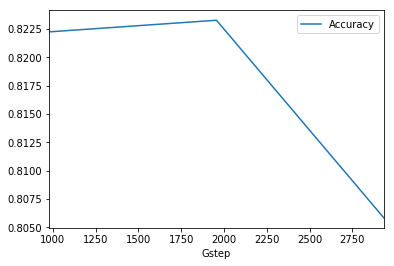

In [39]:
h512_l1_b16.plot(x="Gstep", y="Accuracy")

### Valid Accuracy vs Iterations

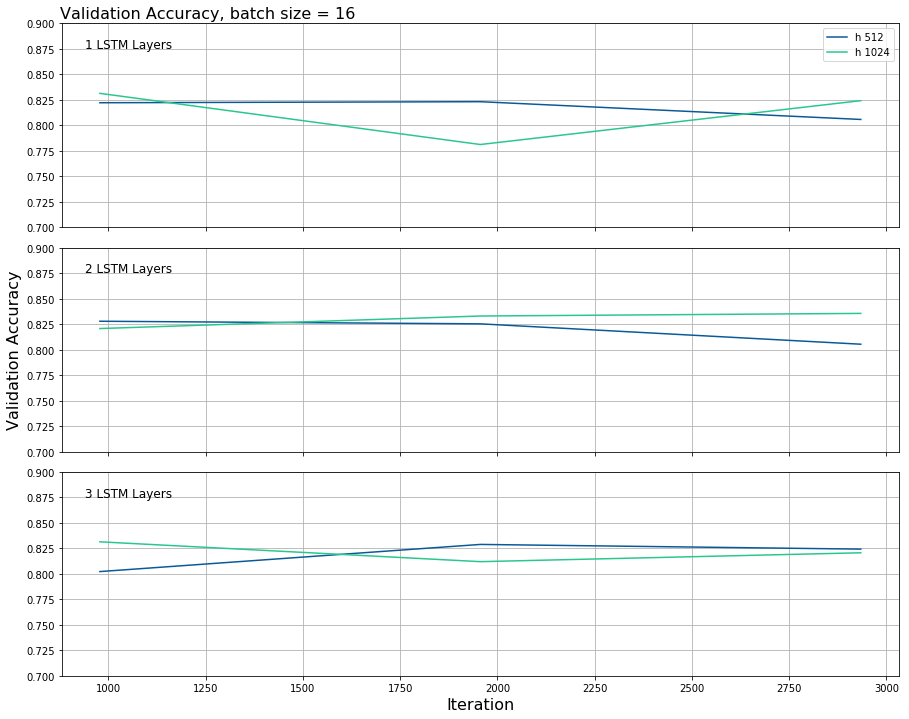

In [46]:
col_pink = '#E13375'
col_blue = '#095998'
col_orange = '#F17B18'
col_green = '#29C78D'
cols = [col_blue, col_green, col_orange, col_pink]
labels = ['h 512', 'h 1024']

h_sizes = [512, 1024]
batch_sizes = [16]
ylims = [
    [0.7, 0.90]
]

bs = 16
bi = 0

fig, ax = plt.subplots(3, 1, figsize=(15,12), sharex=True)

for ls in range(3):
    for hi, hs in enumerate(h_sizes):
        c_layers = valid_df['rnn_layers'] == ls+1
        c_h_size = valid_df['h_size'] == hs
        c_batch  = valid_df['batch_size'] == bs

        plt_df = valid_df[c_layers & c_h_size & c_batch]
    #     plt_df.plot(x="Gstep", y="Accuracy")

        xs = plt_df['Gstep']
        ys = plt_df['Accuracy']
        ax[ls].plot(xs, ys, color=cols[hi], label=labels[hi])
        ax[ls].set_title('{} LSTM Layers'.format(ls+1), y=0.85, x=0.08)
        ax[ls].set_ylim(ylims[bi])
        ax[ls].grid(True)

    if ls == 0:
        ax[0].legend()
    elif ls == 1:
        ax[1].set_ylabel('Validation Accuracy', fontsize=16, y=0.5)
    elif ls == 2:
        ax[2].set_xlabel('Iteration', fontsize=16)

fig.subplots_adjust(hspace=0.1)
fig.suptitle('Validation Accuracy, batch size = {}'.format(bs), fontsize=16, x=0.26, y=0.9)

## Valid Accuracy vs Time

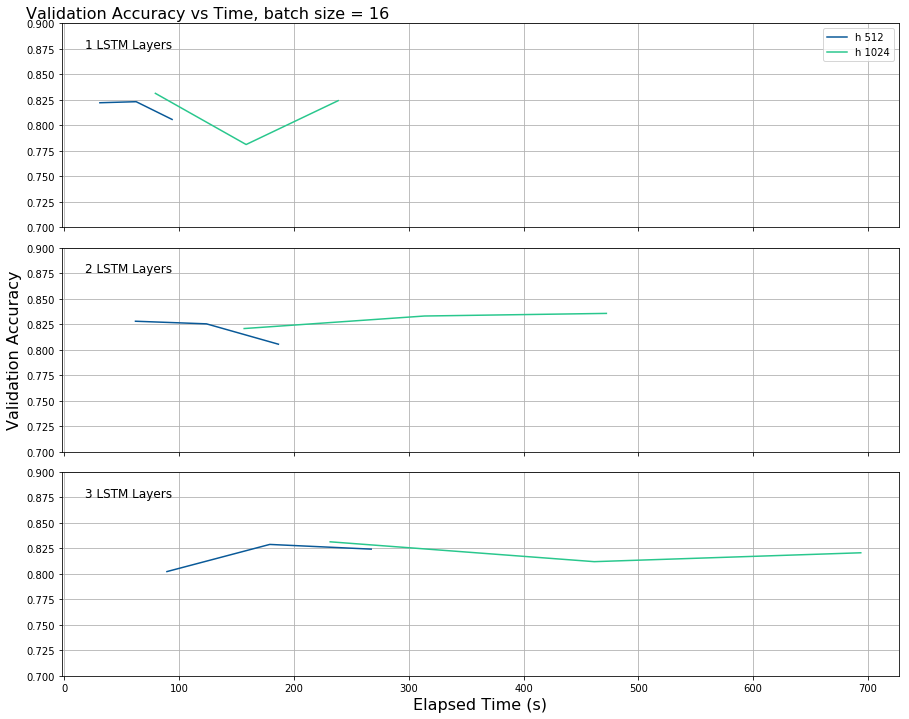

In [48]:
ylims = [
    [0.7, 0.9]
]

bs = 16
bi = 0

fig, ax = plt.subplots(3, 1, figsize=(15,12), sharex=True)

for ls in range(3):
    for hi, hs in enumerate(h_sizes):
        c_layers = valid_df['rnn_layers'] == ls+1
        c_h_size = valid_df['h_size'] == hs
        c_batch  = valid_df['batch_size'] == bs

        plt_df = valid_df[c_layers & c_h_size & c_batch]
    #     plt_df.plot(x="Gstep", y="Accuracy")

        xs = plt_df['Time']
        ys = plt_df['Accuracy']
        ax[ls].plot(xs, ys, color=cols[hi], label=labels[hi])
        ax[ls].set_title('{} LSTM Layers'.format(ls+1), y=0.85, x=0.08)
        ax[ls].set_ylim(ylims[bi])
        ax[ls].grid(True)

    if ls == 0:
        ax[0].legend()
    elif ls == 1:
        ax[1].set_ylabel('Validation Accuracy', fontsize=16, y=0.5)
    elif ls == 2:
        ax[2].set_xlabel('Elapsed Time (s)', fontsize=16)

fig.subplots_adjust(hspace=0.1)
fig.suptitle('Validation Accuracy vs Time, batch size = {}'.format(bs), fontsize=16, x=0.26, y=0.9)

### Valid Loss vs Iterations

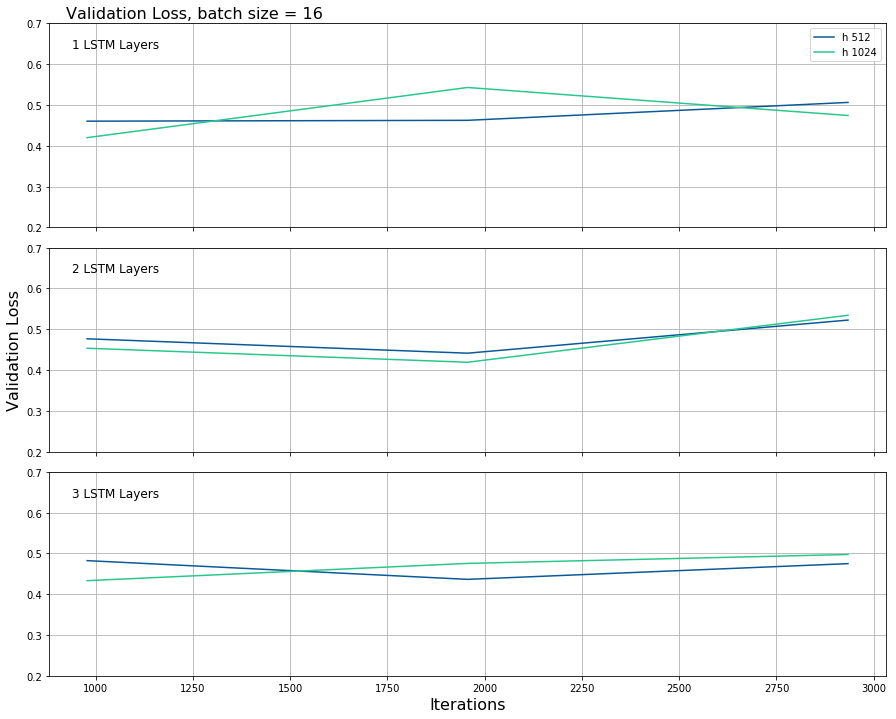

In [52]:
ylims = [
    [0.2, 0.7]
]

bs = 16
bi = 0

fig, ax = plt.subplots(3, 1, figsize=(15,12), sharex=True)

for ls in range(3):
    for hi, hs in enumerate(h_sizes):
        c_layers = valid_df['rnn_layers'] == ls+1
        c_h_size = valid_df['h_size'] == hs
        c_batch  = valid_df['batch_size'] == bs

        plt_df = valid_df[c_layers & c_h_size & c_batch]
    #     plt_df.plot(x="Gstep", y="Accuracy")

        xs = plt_df['Gstep']
        ys = plt_df['Loss']
        ax[ls].plot(xs, ys, color=cols[hi], label=labels[hi])
        ax[ls].set_title('{} LSTM Layers'.format(ls+1), y=0.85, x=0.08)
        ax[ls].set_ylim(ylims[bi])
        ax[ls].grid(True)

    if ls == 0:
        ax[0].legend()
    elif ls == 1:
        ax[1].set_ylabel('Validation Loss', fontsize=16, y=0.5)
    elif ls == 2:
        ax[2].set_xlabel('Iterations', fontsize=16)

fig.subplots_adjust(hspace=0.1)
fig.suptitle('Validation Loss, batch size = {}'.format(bs), fontsize=16, x=0.26, y=0.9)

## Training Plots

Code to plot $\pm 1 \sigma$ bands for the training data. The values used here were chosen to plot another dataset, so the output here is a bit ugly. The code also seems to be slow with so many iterations, so I haven't taken the time to improve the plot quality just now.

In [53]:
import numpy as np
from scipy.interpolate import spline

def mid_running_mean(x, N):
    # Prepad with N/2 values of the average of the first N/2 values, and
    # postpad with N/2 values of the average of the last N/2 values
    # returns an array of the same dimension as x,
    # with average of a window of width N centred on each element
    
    # Average of first N/2 elements, and last N/2 elements
    avg_first = np.cumsum(x[:int(N/2)])[int(N/2)-1]*2/N
    avg_last  = np.cumsum(x[-int(N/2):])[int(N/2)-1]*2/N
    
    prepadding  = np.ones(int(N/2))*avg_first
    postpadding = np.ones(int(N/2))*avg_last
    pad_losses  = np.hstack((prepadding, x, postpadding))
    cumsum = np.cumsum(pad_losses)
    return (cumsum[N:] - cumsum[:-N]) / N

def running_mean_sig_bands(x, y, N, spline_points=20):
    y_sum = np.cumsum(y)
    half_win = int(N/2)
    
    means = []
    std_up = []
    std_dn = []
    for i, val in enumerate(np.nditer(y)):
        step = i+1
        remain = len(y)-step
#         win = min(int(N/2)+step, N, int(N/2)+(len(x)-step))
        if i < half_win:
            win = half_win + i
            mean = y_sum[win-1]/win
            std = np.std(y[:win])            
        elif remain < half_win:
            win = half_win + remain
            mean = (y_sum[-1]-y_sum[-win-1])/win
            std = np.std(y[-win:])
        else:
            mean = (y_sum[i+half_win]-y_sum[i-half_win])/N
            std = np.std(y[i-half_win:i+half_win])
#             if i < (half_win + 3):
#                 print(i, i-half_win, x_sum[i-half_win])
        #print('{:5} {:7.3f} {:7.3f} {:5} {:5} {:5} {:5}'.format(i, mean, std, step, remain, half_win, win))
        means.append(mean)
        std_up.append(mean+std)
        std_dn.append(mean-std)
    
    # Smoothing error lines
    err_xs = np.linspace(x.min(), x.max(), spline_points)
    err_up = spline(x, std_up, err_xs)
    err_dn = spline(x, std_dn, err_xs)
    return means, err_xs, err_up, err_dn

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


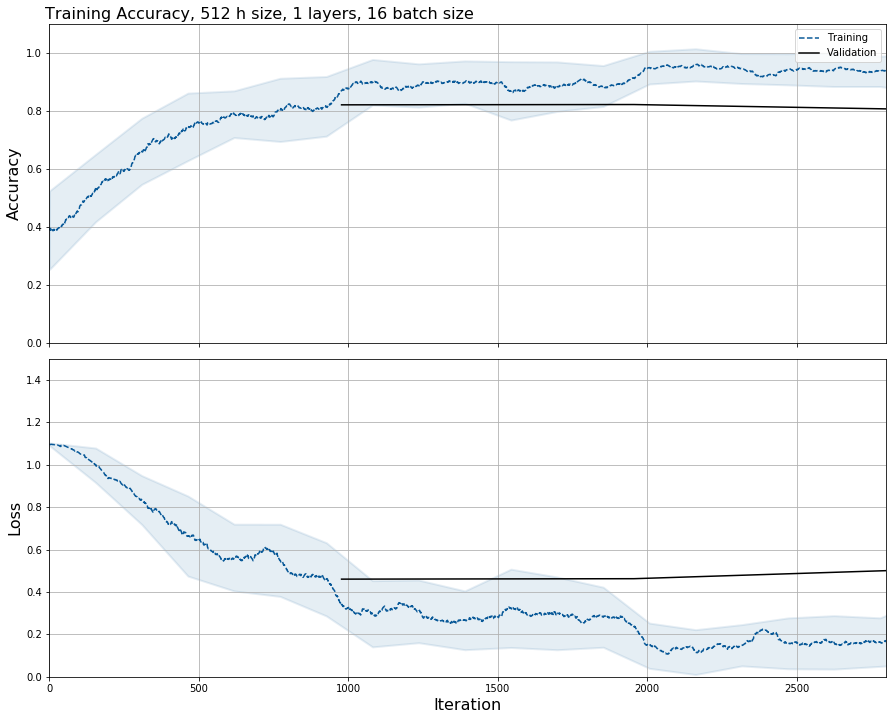

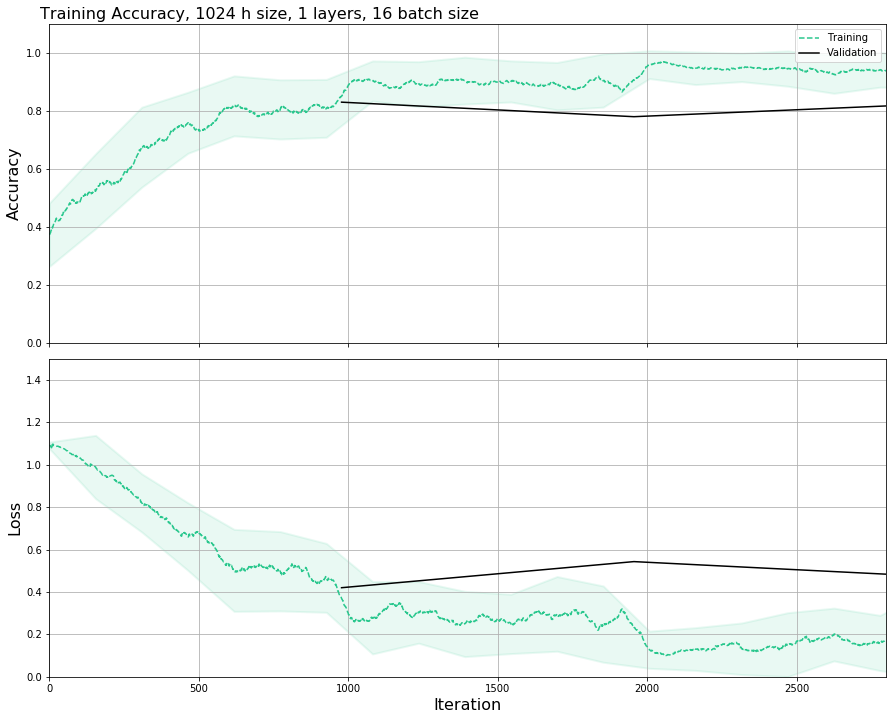

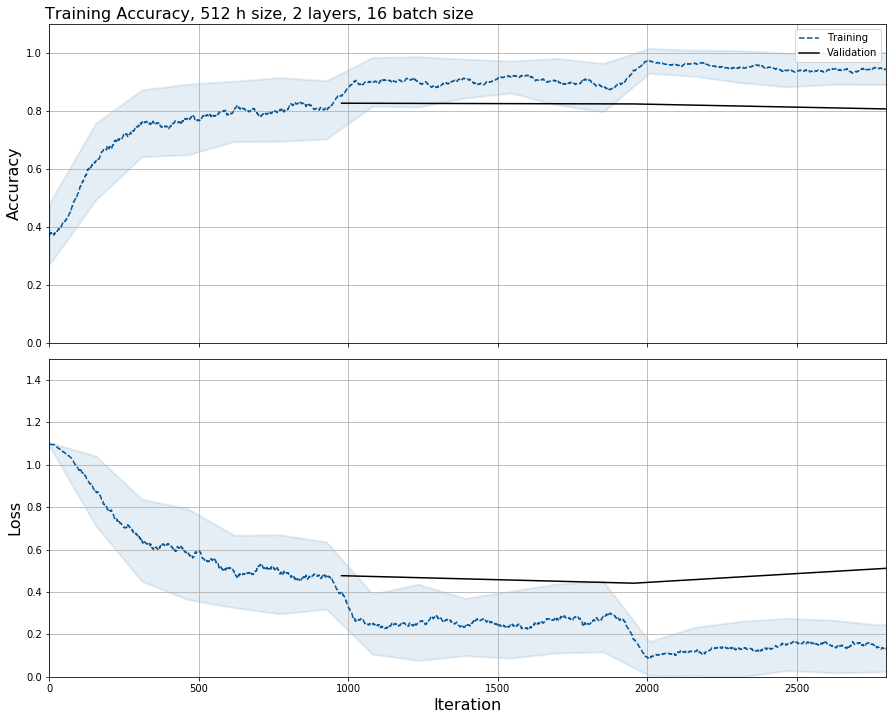

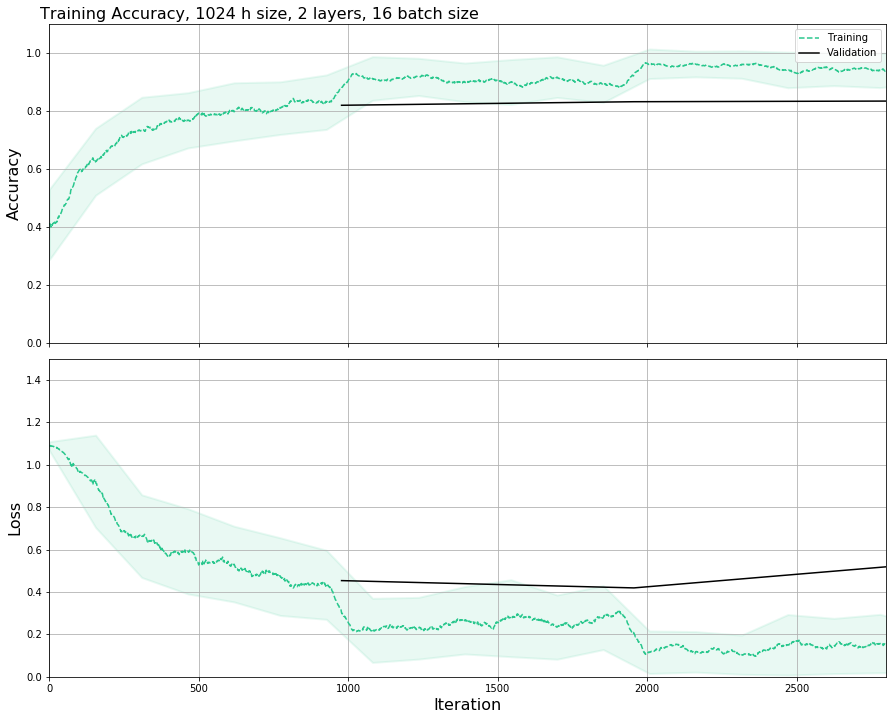

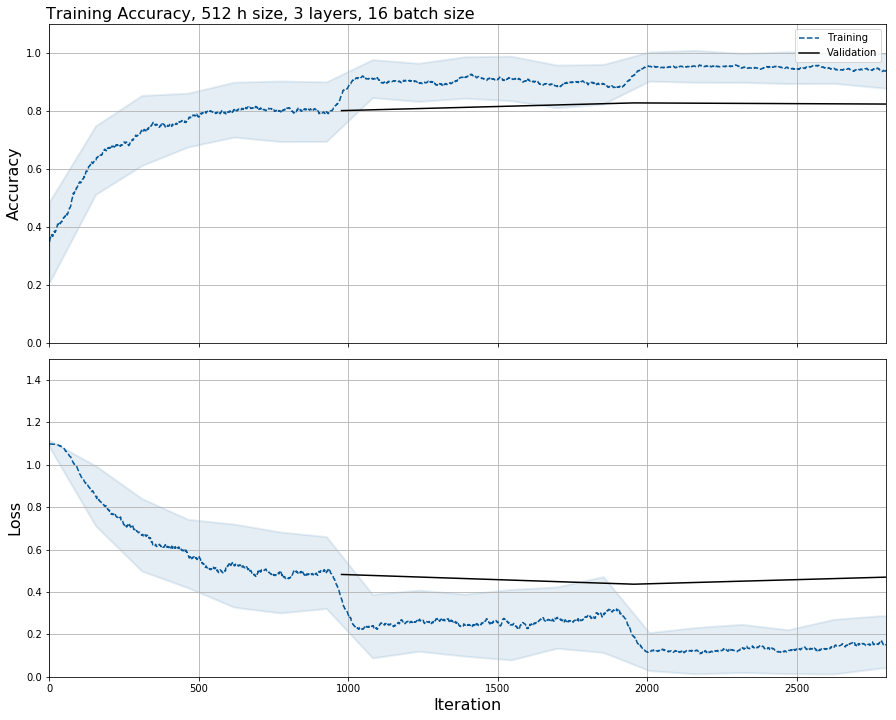

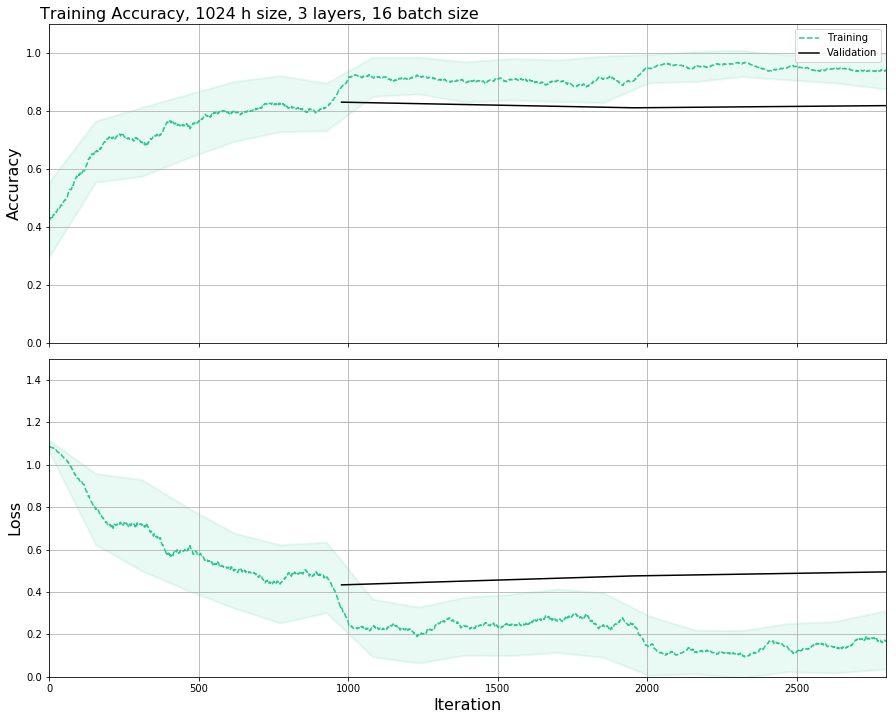

In [55]:
ylims = [
    [0.0, 1.10],
    [0.0, 1.50]
]

xlims = [
    [0, 2800],
    [0, 2800]
]

batches = [16]
layers = [1, 2, 3]
h_sizes = [512, 1024]

def get_sub_df(df, rnn_layers=1, h_size=256, batch_size=32):
    c_layers = df['rnn_layers'] == rnn_layers
    c_h_size = df['h_size'] == h_size
    c_batch  = df['batch_size'] == batch_size
    return df[c_layers & c_h_size & c_batch]
    
bs = 16
bi = 0

for ls in layers:
    for hi, hs in enumerate(h_sizes):

        fig, ax = plt.subplots(2, 1, figsize=(15,12), sharex=True)

        plt_t_df = get_sub_df(train_df, rnn_layers=ls, h_size=hs, batch_size=bs)

        xs = plt_t_df['Gstep']
        ys = plt_t_df['Accuracy']
        means, err_xs, err_up, err_dn = running_mean_sig_bands(xs.values, ys.values, 80)

#             ax[0].plot(xs, ys, color=cols[hi])
        ax[0].plot(xs, means, '--', color=cols[hi], label='Training')
        ax[0].fill_between(err_xs, err_dn, err_up, facecolor=cols[hi], edgecolor=cols[hi],
                            linewidth=2.0, alpha=0.1, antialiased=True)

        #
        plt_v_df = get_sub_df(valid_df, rnn_layers=ls, h_size=hs, batch_size=bs)

        xs = plt_v_df['Gstep']
        ys = plt_v_df['Accuracy']

        ax[0].plot(xs, ys, color='k', label='Validation')

        ax[0].set_ylim(ylims[0])
        ax[0].set_xlim(xlims[0])
        ax[0].grid(True)

        ax[0].set_ylabel('Accuracy', fontsize=16)
        ax[0].legend()


        xs = plt_t_df['Gstep']
        ys = plt_t_df['Loss']
        means, err_xs, err_up, err_dn = running_mean_sig_bands(xs.values, ys.values, 80)

#             ax[1].plot(xs, ys, color=cols[hi], label=labels[hi])
        ax[1].plot(xs, means, '--', color=cols[hi], label=labels[hi])
        ax[1].fill_between(err_xs, err_dn, err_up, facecolor=cols[hi], edgecolor=cols[hi],
                            linewidth=2.0, alpha=0.1, antialiased=True)

        xs = plt_v_df['Gstep']
        ys = plt_v_df['Loss']
        ax[1].plot(xs, ys, color='k', label='Validation')

        ax[1].set_ylim(ylims[1])
        ax[1].set_xlim(xlims[1])
        ax[1].grid(True)

        ax[1].set_ylabel('Loss', fontsize=16)
        ax[1].set_xlabel('Iteration', fontsize=16)

        fig.subplots_adjust(hspace=0.05)
        fig.suptitle('Training Accuracy, {} h size, {} layers, {} batch size'.format(hs, ls, bs),
                     fontsize=16, x=0.32, y=0.9)